# Neccesary modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Get the data

In [2]:
background = np.load("background_rf_LH_normalized.npy")
drone = np.load("drone_rf_LH_normalized.npy")

In [3]:
print(background.shape)
print(drone.shape)

(41, 2, 10000000, 1)
(39, 2, 10000000, 1)


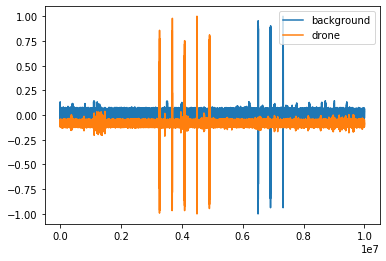

In [31]:
num = random.randint(0, len(background)-1)
channel = 1
plt.plot(background[num][channel], label="background")
plt.plot(drone[num][channel],label="drone")
plt.legend(loc='upper right')

# Train/ test split and data formatting

In [5]:
Y = np.array([0 for i in enumerate(background)] + [1 for i in enumerate(drone)])
X = np.append(background,drone,axis=0)
Y = Y.reshape(-1,1)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [15]:
def split_rf(x_data):
    low = []
    high = []
    for x in x_data:
        low.append(x[0].flatten())
        high.append(x[1].flatten())
    low = np.array(low)
    high = np.array(high)
    return [low, high]
x_train = split_rf(x_train)
x_test = split_rf(x_test)
    

In [32]:
x_train[0]

array([[ 0.27504204, -0.03723276, -0.2404516 , ..., -0.0084074 ,
         0.1371607 , -0.09776603],
       [ 0.00135283,  0.0014401 ,  0.00091643, ...,  0.00091643,
         0.00100371,  0.00109099],
       [-0.02287732, -0.02326117, -0.02303086, ..., -0.02349148,
        -0.0231844 , -0.02326117],
       ...,
       [ 0.0552795 ,  0.05714286,  0.05714286, ...,  0.05465839,
         0.0552795 ,  0.05403727],
       [ 0.05394191, -0.01244813, -0.0373444 , ..., -0.01244813,
         0.01244813,  0.00414938],
       [-0.03187466, -0.03144246, -0.03133441, ..., -0.03144246,
        -0.03155051, -0.03155051]])

# Model Specification

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.layers import Input


# define two sets of inputs
low_rf  = Input(shape=(X.shape[2],))
high_rf = Input(shape=(X.shape[2],))

# the first branch operates on the first input
x1 = Dense(10000 , activation="relu")(low_rf)
x1 = Dense(500, activation="relu")(x1)
x1 = Model(inputs=low_rf, outputs=x1)

# the second branch operates on the second input
x2 = Dense(10000 , activation="relu")(high_rf)
x2 = Dense(500, activation="relu")(x2)
x2 = Model(inputs=high_rf, outputs=x2)

# combine the output of the two branches
combined = concatenate([x1.output, x2.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(100, activation="relu")(combined)
z = Dense(1, activation="softmax")(z)

model = Model(inputs=[x1.input, x2.input], outputs=z)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10000000)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10000000)]   0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 10000)        1215762192  input_3[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 10000)        1215762192  input_4[0][0]                    
____________________________________________________________________________________________

C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\utils\layer_utils.py:82: RuntimeWarning: overflow encountered in long_scalars
  for p in object_identity.ObjectIdentitySet(weights)))


In [21]:
model.compile(optimizer ='adam' , loss = "binary_crossentropy", metrics=["accuracy"])

# Train Model

In [22]:
batch_size =4
epochs = 10
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 64 samples, validate on 16 samples


InvalidArgumentError: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 10000000
  }
  dim {
    size: 10000
  }
}
float_val: 0

	 [[node training_2/Adam/dense_8/kernel/v/Initializer/zeros (defined at C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'training_2/Adam/dense_8/kernel/v/Initializer/zeros':
  File "C:\Users\nihad\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\nihad\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\nihad\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\nihad\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\nihad\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\nihad\Anaconda3\lib\asyncio\base_events.py", line 539, in run_forever
    self._run_once()
  File "C:\Users\nihad\Anaconda3\lib\asyncio\base_events.py", line 1775, in _run_once
    handle._run()
  File "C:\Users\nihad\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\nihad\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\nihad\Anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\nihad\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\nihad\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\nihad\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\nihad\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\nihad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\nihad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-bab5d9530b26>", line 7, in <module>
    validation_data=(x_test, y_test))
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\training.py", line 727, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\training_arrays.py", line 675, in fit
    steps_name='steps_per_epoch')
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\training_arrays.py", line 189, in model_iteration
    f = _make_execution_function(model, mode)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\training_arrays.py", line 566, in _make_execution_function
    return model._make_execution_function(mode)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\training.py", line 2183, in _make_execution_function
    self._make_train_function()
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\training.py", line 2115, in _make_train_function
    params=self._collected_trainable_weights, loss=self.total_loss)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py", line 504, in get_updates
    return [self.apply_gradients(grads_and_vars)]
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py", line 433, in apply_gradients
    self._create_slots(var_list)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\optimizer_v2\adam.py", line 151, in _create_slots
    self.add_slot(var, 'v')
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py", line 585, in add_slot
    initial_value=initial_value)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\variables.py", line 260, in __call__
    return cls._variable_v2_call(*args, **kwargs)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\variables.py", line 254, in _variable_v2_call
    shape=shape)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\variables.py", line 235, in <lambda>
    previous_getter = lambda **kws: default_variable_creator_v2(None, **kws)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\variable_scope.py", line 2552, in default_variable_creator_v2
    shape=shape)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\variables.py", line 262, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 1406, in __init__
    distribute_strategy=distribute_strategy)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\resource_variable_ops.py", line 1537, in _init_from_args
    initial_value() if init_from_fn else initial_value,
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\init_ops.py", line 114, in __call__
    return array_ops.zeros(shape, dtype)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\array_ops.py", line 2350, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\array_ops.py", line 171, in fill
    result = gen_array_ops.fill(dims, value, name=name)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\gen_array_ops.py", line 3602, in fill
    "Fill", dims=dims, value=value, name=name)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "C:\Users\nihad\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
